**Info**: This separated notebooks contains notes on scraping the **evolution** of a select few repos in our sample + doing the science.

# Replay history (all-contrib)

Prototyping

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline
clist = ['#fcfdfe','#1f77b4',  'orange', 'red']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats

In [2]:
def purge_bots(data):
    bots = {None, "allcontributors", "renovate",  "stale", "github-actions", "dependabot", "fossabot", "imgbot"} 
    # will also match on logins ending in -bot and [bot]
    
    # these users have a login that does not contain bot but they are boths
    bots = {None, "allcontributors", "renovate",  "stale", "github-actions"} 
    # these users have a login ending in "bot" but they are not bots
    safe = {"adamscybot", "aktsbot", "andrebot", "apirobot", "bashfulrobot", "bchrobot", "benbot", "bobtherobot", "boenrobot", "ceejbot", "charliesbot", "chri5bot", "danobot", "dawsbot", "Ddbot", "dev-rowbot", "domtalbot", "goaddbot", "ichabot", "joshuabot", "jotterbot", "Jugbot", "jukbot", "kebot", "Labrobot", "LionelMarbot", "mikechabot", "mikhailbot", "muta-robot", "namithubot", "naviabbot", "olgabot", "p3x-robot", "reconbot", "sagalbot", "shawnbot", "sunlingbot", "the-robot", "therebelrobot", "ttalbot", "VincentNarbot", "webot", "wootsbot", "yonibot", "ytkopobot"}


    accu = 0
    clean_list = []
    for user in data:
        login = user.get('login')
        if login is None:
            login = user.get('name') # will discount as bot if "name" is also none
        if (login in bots or login[-3:] == "bot" or login[-4:] == "-bot" or login[-5:] == "[bot]") and login not in safe:
            accu += 1
        else:
            clean_list.append(user.copy())
    return clean_list

In [3]:
fpath = "/storage/MSR2021/git_folders/all-contributors/__contributor_history.pck"

with open(fpath, 'rb') as f:
    data = pickle.load(f)

# clean from invalid format
to_delete = []
for k in data:
    if data[k].get('contributors') is None:
        to_delete.append(k)
    else:
        data[k] = data[k]['contributors']
for k in to_delete:
    del data[k]
    
# remove bot
for k in data:
    data[k] = purge_bots(data[k])

# sort in temporal order
sorted_keys = sorted(data, key=lambda x: x[1])



In [4]:
t = [(k[1] - sorted_keys[0][1]).days + (k[1] - sorted_keys[0][1]).seconds / (24 * 3600) for k in sorted_keys]
num_contrib = [len(data[k]) for k in sorted_keys]

Text(0, 0.5, 'Number of contributors')

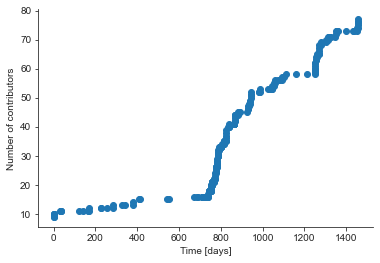

In [5]:
plt.scatter(t, num_contrib)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Number of contributors')

Final loop creating data

In [7]:
# coarse-craining of AC contributions:
category = {"audio": "education-outreach",
            "a11y": "artifacts",
            "bug": "maintenance",
            "fix": "maintenance",   # non-native
            "blog": "education-outreach",
            "business": "lead",
            "marketing": "lead",   # non-native
            "code": "artifacts",
            "content": "education-outreach",
            "data": "artifacts",
            "doc": "artifacts",
            "docs": "artifacts",   # non-native
            "documentation": "artifacts",   # non-native
            "design": "artifacts",
            "theme": "artifacts",   # non-native
            "example": "education-outreach",
            "examples": "education-outreach",
            "eventOrganizing": "education-outreach",
            "financial": "lead",
            "fundingFinding": "lead",
            "ideas": "lead",
            "infra": "support",
            "maintenance": "maintenance",
            "mentoring": "education-outreach",
            "platform": "support",
            "plugin": "artifacts",
            "projectManagement": "lead",
            "question": "education-outreach",
            "research": "lead",
            "review": "maintenance",
            "security": "support",
            "tool": "artifacts",
            "translation": "artifacts",
            "test": "artifacts",
            "tutorial": "education-outreach",
            "talk": "education-outreach",
            "userTesting": "artifacts",
            "video": "education-outreach"}
# note I gave *some leeway* and classified non-existant categories, and alowed typos:
# typos:
#  docs -> doc -> artifact
#  documentation -> doc -> artifact
# classify:
#  theme -> design -> artifact
#  fix -> bug -> maintenance
#  marketing -> Business -> lead

In [8]:
import os

db = dict()

for d in os.listdir("/storage/MSR2021/git_folders/"):
    fpath = "/storage/MSR2021/git_folders/" + d + "/__contributor_history.pck"

    with open(fpath, 'rb') as f:
        contribution_history = pickle.load(f)

    # clean from invalid format
    to_delete = []
    for k in contribution_history:
        if contribution_history[k] is None:
            to_delete.append(k)
        elif contribution_history[k].get('contributors') is None:
            to_delete.append(k)
        else:
            contribution_history[k] = contribution_history[k]['contributors']
    for k in to_delete:
        del contribution_history[k]

    # remove bot
    for k in contribution_history:
        contribution_history[k] = purge_bots(contribution_history[k])

    # sort in temporal order
    sorted_keys = sorted(contribution_history, key=lambda x: x[1])

    t = [(k[1] - sorted_keys[0][1]).days + (k[1] - sorted_keys[0][1]).seconds / (24 * 3600) for k in sorted_keys]
    
    contributors = set()
    contributions = set()
    size = []
    cumul_size = []
    num_types_cumul = []
    for k in sorted_keys:
        contributors |= {u.get('login') if u.get('login') is not None else u.get('name') for u in contribution_history[k]}
        raw_contributions = {x for u in contribution_history[k]  if u.get('contributions') is not None for x in u.get('contributions')}
        size.append(len(contribution_history[k]))
        cumul_size.append(len(contributors))
        
        for c in raw_contributions:
            try:
                contributions.add(category[c])
            except:
                continue
        num_types_cumul.append(len(contributions))
    
    db[d] = (t, size, cumul_size, num_types_cumul)

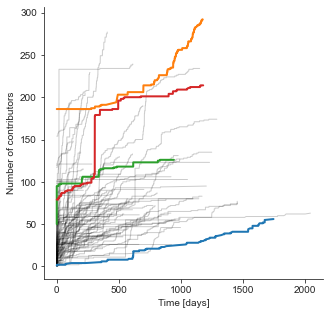

In [10]:
plt.figure(figsize=(5, 5))
for k in db:
    plt.plot(np.array(db[k][0]), np.array(db[k][2]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(np.array(db[hl][0]), np.array(db[hl][2]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Number of contributors')


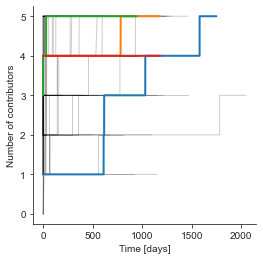

In [11]:
plt.figure(figsize=(4, 4))

for k in db:
    plt.plot(np.array(db[k][0]), np.array(db[k][3]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(np.array(db[hl][0]), np.array(db[hl][3]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Number of contributors')


Who are we including?

In [12]:
sorted(db, key=lambda k: max(db[k][0]), reverse=True)

['cssnano',
 'all-contributors-cli',
 'awesome-cms',
 'all-contributors',
 'codesandbox-client',
 'downshift',
 'netlify-cms',
 'git-point',
 'snipe-it',
 'p5.js',
 'carbon',
 'transcripts',
 'nerd-fonts',
 'interactive-examples',
 'Front-end-Developer-Interview-Questions',
 'isomorphic-git',
 'jest-dom',
 'react-testing-library',
 'dom-testing-library',
 'medellinjs',
 'Fork-Awesome',
 'nothing-private',
 'codebuddies',
 'show-notes',
 'bionode',
 'night',
 'typescript-book-chinese',
 'user-event',
 'awesome-raspberry-pi',
 'bootcamp',
 'gh',
 'kentcdodds.com',
 'cypress-file-upload',
 'plugin-ruby',
 'uno',
 'graphql-hooks',
 'the-turing-way',
 'barba',
 'glamorous',
 'testing-library-docs',
 'watchtower',
 'docs',
 'create-content-loader',
 'Fomantic-UI',
 'OpenCiviWiki',
 'ml5-library',
 'pyproj',
 'nodebestpractices',
 'vdb',
 'platform',
 'takenote',
 'book',
 'ferdi',
 'plugin.video.hbogoeu',
 'You-Dont-Know-JS',
 'ethereum-org-website',
 'tinacms',
 'tsdx',
 'eCobidas',
 'CLI11

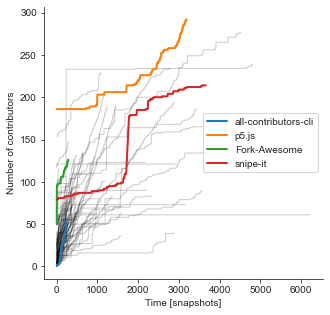

In [13]:
plt.figure(figsize=(5, 5))
for k in db:
    plt.plot(range(len(db[k][0])), np.array(db[k][2]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(range(len(db[hl][0])), np.array(db[hl][2]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [snapshots]")
plt.ylabel('Number of contributors')
plt.legend()


Entropy:

In [14]:
def get_entropy(contributors, coarse=True):
    users_to_num_contrib_types = dict()  # keys: user, values: number of tasks done by user
    contrib_types_to_num_users = dict()  # keys: tasks type, value: num user with task type
    for user in contributors:
        login = user.get('login')
        if login is None:
            login = user.get('name')
        if login is None:
            continue
        contrib_done = set()
        if user.get("contributions") is None:
            continue
        for c in user.get("contributions"):
            try:
                if coarse:
                    contrib = category[c]
                else:
                    contrib = c
                contrib_done.add(contrib)
                if contrib_types_to_num_users.get(contrib) is None:
                    contrib_types_to_num_users[contrib] = 1
                else:
                    contrib_types_to_num_users[contrib] += 1
            except:
                continue
        users_to_num_contrib_types[login] = len(contrib_done)
        
    # conver to list
    num_contrib_types = [users_to_num_contrib_types[u] for u in users_to_num_contrib_types]
    num_users = [contrib_types_to_num_users[c] for c in contrib_types_to_num_users]
    return (scipy.stats.entropy(num_contrib_types),# Contributor entropy
            scipy.stats.entropy(num_users))  # Task entropy

In [15]:
import os

db = dict()

for d in os.listdir("/storage/MSR2021/git_folders/"):
    fpath = "/storage/MSR2021/git_folders/" + d + "/__contributor_history.pck"

    with open(fpath, 'rb') as f:
        contribution_history = pickle.load(f)

    # clean from invalid format
    to_delete = []
    for k in contribution_history:
        if contribution_history[k] is None:
            to_delete.append(k)
        elif contribution_history[k].get('contributors') is None:
            to_delete.append(k)
        else:
            contribution_history[k] = contribution_history[k]['contributors']
    for k in to_delete:
        del contribution_history[k]

    # remove bot
    for k in contribution_history:
        contribution_history[k] = purge_bots(contribution_history[k])

    # sort in temporal order
    sorted_keys = sorted(contribution_history, key=lambda x: x[1])
    
    S = np.zeros((len(sorted_keys), 2))
    for i, k in enumerate(sorted_keys):
        res = get_entropy(contribution_history[k])
        S[i, 0] = res[0]
        S[i, 1] = res[1]
    db[d] = ([(k[1] - sorted_keys[0][1]).days + (k[1] - sorted_keys[0][1]).seconds / (24 * 3600) for k in sorted_keys],
             S)

Plot with coarsening

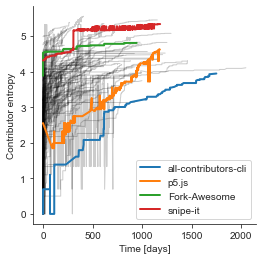

In [16]:
plt.figure(figsize=(4, 4))
for k in db:
    plt.plot(np.array(db[k][0]), np.array(db[k][1][:,0]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(np.array(db[hl][0]), np.array(db[hl][1][:,0]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Contributor entropy')
plt.legend()



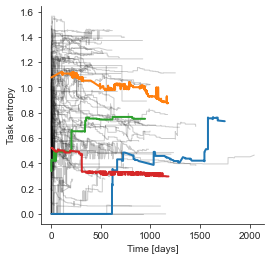

In [17]:
plt.figure(figsize=(4, 4))
for k in db:
    plt.plot(np.array(db[k][0]), np.array(db[k][1][:,1]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(np.array(db[hl][0]), np.array(db[hl][1][:,1]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Task entropy')
# plt.legend()

plt.savefig('../../notebooks/figs/evolution_task_entropy.pdf', bbox_inches='tight')

Recompute without coarsening

In [18]:
import os

db = dict()

for d in os.listdir("/storage/MSR2021/git_folders/"):
    fpath = "/storage/MSR2021/git_folders/" + d + "/__contributor_history.pck"

    with open(fpath, 'rb') as f:
        contribution_history = pickle.load(f)

    # clean from invalid format
    to_delete = []
    for k in contribution_history:
        if contribution_history[k] is None:
            to_delete.append(k)
        elif contribution_history[k].get('contributors') is None:
            to_delete.append(k)
        else:
            contribution_history[k] = contribution_history[k]['contributors']
    for k in to_delete:
        del contribution_history[k]

    # remove bot
    for k in contribution_history:
        contribution_history[k] = purge_bots(contribution_history[k])

    # sort in temporal order
    sorted_keys = sorted(contribution_history, key=lambda x: x[1])
    
    S = np.zeros((len(sorted_keys), 2))
    for i, k in enumerate(sorted_keys):
        res = get_entropy(contribution_history[k], coarse=False)
        S[i, 0] = res[0]
        S[i, 1] = res[1]
    db[d] = ([(k[1] - sorted_keys[0][1]).days + (k[1] - sorted_keys[0][1]).seconds / (24 * 3600) for k in sorted_keys],
             S)

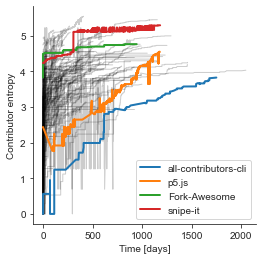

In [19]:
plt.figure(figsize=(4, 4))
for k in db:
    plt.plot(np.array(db[k][0]), np.array(db[k][1][:,0]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(np.array(db[hl][0]), np.array(db[hl][1][:,0]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Contributor entropy')
plt.legend()


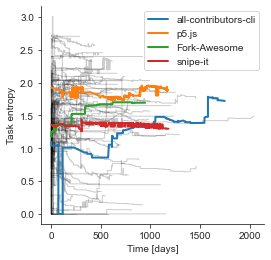

In [20]:
plt.figure(figsize=(4, 4))
for k in db:
    plt.plot(np.array(db[k][0]), np.array(db[k][1][:,1]), lw=1, c='k', alpha=0.2, label='')


    
for idx, hl in enumerate(['all-contributors-cli', 'p5.js', 'Fork-Awesome', "snipe-it"], start=1):
    plt.plot(np.array(db[hl][0]), np.array(db[hl][1][:,1]), lw=2, alpha=1, label=hl)
sns.despine()
plt.xlabel("Time [days]")
plt.ylabel('Task entropy')
plt.legend()

